# Abstract
### The following notebook aims to help understand the effect of hyperparameter tuning on a deep learning model(CNN). A model is built to read SMS spam data (<a href = "https://www.kaggle.com/uciml/sms-spam-collection-dataset">link</a>) and classify text as either "Spam" or "Ham". The initial part of the notebook is mainly data exploration and data preprocessing. In the second half, a baseline model is established and the hyperparameters are tuned to understand how the performance varies with the tuning.

First, we install some libraries: <small>*</small>

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Styles
plt.style.use('ggplot')
sns.set_style('whitegrid')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['patch.force_edgecolor'] = True

# Text Preprocessing
import nltk
# nltk.download("all")
from nltk.corpus import stopwords
import string
from nltk.tokenize import word_tokenize

import spacy
nlp = spacy.load("en")

AttributeError: module 'spacy.lang' has no attribute 'load'

In [10]:
path = 'C://Users/Karti/NEU/7390 Adv DS - Prof Nik/INFO_7390/Assignments/Assignment3' #csv file stored in this folder

In [42]:
messages = pd.read_csv(path+"/spam.csv", encoding = 'latin-1')

# Drop the extra columns and rename columns

messages = messages.drop(labels = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis = 1)
messages.columns = ["category", "text"]

In [12]:
display(messages.head(n = 10))

,category,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [13]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
category    5572 non-null object
text        5572 non-null object
dtypes: object(2)
memory usage: 87.2+ KB


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


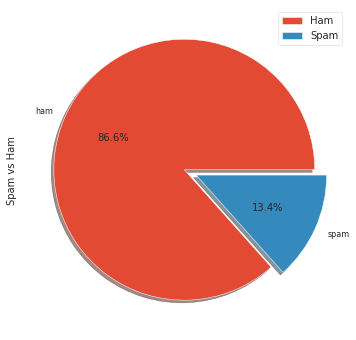

In [14]:
messages["category"].value_counts().plot(kind = 'pie', explode = [0, 0.1], figsize = (6, 6), autopct = '%1.1f%%', shadow = True)
plt.ylabel("Spam vs Ham")
plt.legend(["Ham", "Spam"])
plt.show()

In [15]:
#top messages by frequency
topMessages = messages.groupby("text")["category"].agg([len, np.max]).sort_values(by = "len", ascending = False).head(n = 10)
display(topMessages)

,len,amax
text,,
"Sorry, I'll call later",30,ham
I cant pick the phone right now. Pls send a message,12,ham
Ok...,10,ham
Your opinion about me? 1. Over 2. Jada 3. Kusruthi 4. Lovable 5. Silent 6. Spl character 7. Not matured 8. Stylish 9. Simple Pls reply..,4,ham
"Wen ur lovable bcums angry wid u, dnt take it seriously.. Coz being angry is d most childish n true way of showing deep affection, care n luv!.. kettoda manda... Have nice day da.",4,ham
Please call our customer service representative on FREEPHONE 0808 145 4742 between 9am-11pm as you have WON a guaranteed å£1000 cash or å£5000 prize!,4,spam
Okie,4,ham
"Say this slowly.? GOD,I LOVE YOU &amp; I NEED YOU,CLEAN MY HEART WITH YOUR BLOOD.Send this to Ten special people &amp; u c miracle tomorrow, do it,pls,pls do it...",4,ham
"7 wonders in My WORLD 7th You 6th Ur style 5th Ur smile 4th Ur Personality 3rd Ur Nature 2nd Ur SMS and 1st \Ur Lovely Friendship\""... good morning dear""",4,ham


In [43]:
spam_messages = messages[messages["category"] == "spam"]["text"]
ham_messages = messages[messages["category"] == "ham"]["text"]

spam_words = []
ham_words = []

# Since this is just classifying the message as spam or ham, we can use isalpha(). 
# This will also remove the not word in something like can't etc. 
# In a sentiment analysis setting, its better to use 
# sentence.translate(string.maketrans("", "", ), chars_to_remove)

def extractSpamWords(spamMessages):
    global spam_words
    words = [word.lower() for word in word_tokenize(spamMessages) if word.lower() not in stopwords.words("english") and word.lower().isalpha()]
    spam_words = spam_words + words
    
def extractHamWords(hamMessages):
    global ham_words
    words = [word.lower() for word in word_tokenize(hamMessages) if word.lower() not in stopwords.words("english") and word.lower().isalpha()]
    ham_words = ham_words + words

# spam_messages.apply(extractSpamWords)
# ham_messages.apply(extractHamWords)

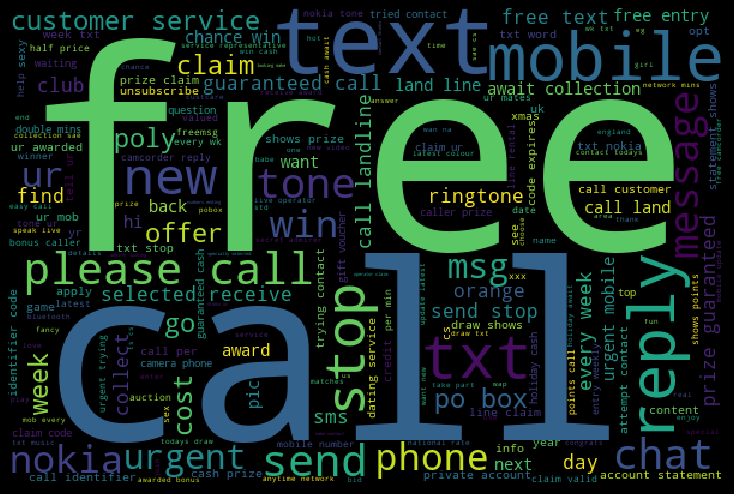

In [17]:
from wordcloud import WordCloud
#Spam Word cloud

spam_wordcloud = WordCloud(width=600, height=400).generate(" ".join(spam_words))
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

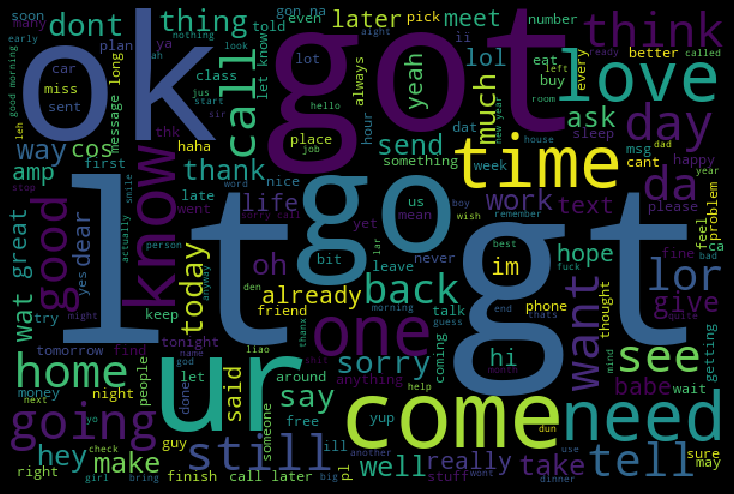

In [18]:
#Ham word cloud

ham_wordcloud = WordCloud(width=600, height=400).generate(" ".join(ham_words))
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(ham_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [19]:
# Top 10 spam words
spam_words = np.array(spam_words)
print("Top 10 Spam words are :\n")
pd.Series(spam_words).value_counts().head(n = 10)

Top 10 Spam words are :



call      346
free      217
txt       156
ur        144
u         144
mobile    123
text      121
stop      114
claim     113
reply     104
dtype: int64

In [48]:
messages["messageLength"] = messages["text"].apply(len)
messages["messageLength"].describe()

count    5572.000000
mean       80.118808
std        59.690841
min         2.000000
25%        36.000000
50%        61.000000
75%       121.000000
max       910.000000
Name: messageLength, dtype: float64

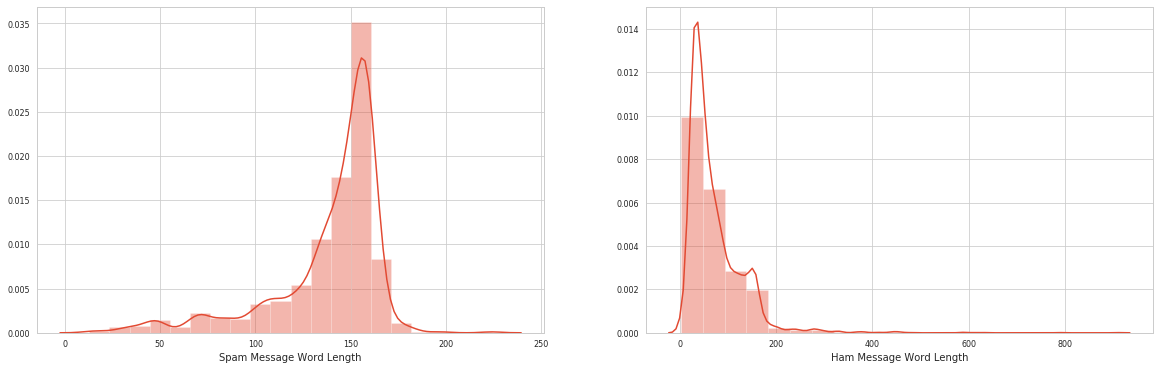

In [49]:
f, ax = plt.subplots(1, 2, figsize = (20, 6))

sns.distplot(messages[messages["category"] == "spam"]["messageLength"], bins = 20, ax = ax[0])
ax[0].set_xlabel("Spam Message Word Length")

sns.distplot(messages[messages["category"] == "ham"]["messageLength"], bins = 20, ax = ax[1])
ax[1].set_xlabel("Ham Message Word Length")

plt.show()

In [50]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer("english")

def cleanText(message):
    
    message = message.translate(str.maketrans('', '', string.punctuation))
    words = [stemmer.stem(word) for word in message.split() if word.lower() not in stopwords.words("english")]
    
    return " ".join(words)

messages["text"] = messages["text"].apply(cleanText)
messages.head(n = 10)    

,category,text,messageLength
0,ham,go jurong point crazi avail bugi n great world...,111
1,ham,ok lar joke wif u oni,29
2,spam,free entri 2 wkli comp win fa cup final tkts 2...,155
3,ham,u dun say earli hor u c alreadi say,49
4,ham,nah dont think goe usf live around though,61
5,spam,freemsg hey darl 3 week word back id like fun ...,148
6,ham,even brother like speak treat like aid patent,77
7,ham,per request mell mell oru minnaminungint nurun...,160
8,spam,winner valu network custom select receivea å£9...,158
9,spam,mobil 11 month u r entitl updat latest colour ...,154


In [23]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

In [24]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
# normal LSTM/GRU and the Version with Cuda
from keras.layers import Dense, Embedding, GRU, LSTM, Dropout, Bidirectional
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam, rmsprop

# keras wrapper for k-fold cross-validation
from keras.wrappers.scikit_learn import KerasClassifier
# normsl cross validation
from sklearn.model_selection import cross_val_score, train_test_split
# cross validation for hyperparameter tuning
from sklearn.model_selection import GridSearchCV


Using TensorFlow backend.


In [25]:
import os
# path = "NEU/7390 Adv DS - Prof Nik/INFO_7390/Assignments/Assignment3"
print(os.listdir(path))

['spam.csv']


In [53]:
#split file line wise and category wise

x_raw = []
y_raw = []

with open(path+"/spam.csv", encoding = "ISO-8859-1") as f:
    for line in f:
        y_raw.append(line.split()[0])
        x_raw.append(' '.join(i for i in line.split()[1:]))
print(y_raw)

['v1,v2,,,', 'ham,"Go', 'ham,Ok', 'spam,Free', 'ham,U', 'ham,"Nah', 'spam,"FreeMsg', 'ham,Even', 'ham,As', 'spam,WINNER!!', 'spam,Had', 'ham,"I\'m', 'spam,"SIX', 'spam,"URGENT!', "ham,I've", 'ham,I', 'spam,"XXXMobileMovieClub:', 'ham,Oh', 'ham,Eh', 'ham,Fine', 'spam,"England', 'ham,Is', 'ham,I\x89Û÷m', 'ham,So', 'ham,Aft', 'ham,Ffffffffff.', 'ham,Just', 'ham,Lol', 'ham,Did', 'ham,"I\'m', 'ham,Ahhh.', 'ham,"Wait', 'ham,Yeah', 'ham,K', 'ham,For', 'spam,Thanks', 'ham,Yup...', 'ham,"Oops,', 'ham,I', 'ham,Anything', 'ham,Hello!', 'ham,Pls', 'ham,"Did', 'spam,07732584351', 'ham,WHO', 'ham,Great!', 'ham,No', "ham,Didn't", 'ham,"Fair', 'ham,"Yeah', 'ham,U', 'ham,What', 'ham,"A', 'ham,K', 'ham,"Wow.', 'spam,SMS.', 'ham,Do', 'spam,"Congrats!', 'ham,"Sorry,', 'ham,Tell', 'ham,Yes..gauti', 'ham,Your', 'ham,Ha', 'ham,Its', 'ham,"Sorry', 'ham,Ok', 'spam,"As', 'ham,"Today', 'spam,"Urgent', 'spam,"Did', 'ham,I', 'ham,Wah', 'ham,Finished', 'ham,HI', 'ham,K..k:)where', 'ham,U', 'ham,I', 'ham,Thats', 'ha

In [57]:
y = [1 if ('ham' in i) else 0 for i in y_raw]

print(max(len(s) for s in x_raw))
print(min(len(s)for s in x_raw))
sorted_X = sorted(len(s) for s in x_raw)
print(sorted_X[len(sorted_X) // 2])
print(y)


909
0
60
[0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [58]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_raw)
sequences = tokenizer.texts_to_sequences(x_raw)

vocab_size = len(tokenizer.word_index)+1
print(vocab_size)

8734


In [59]:
sum([len(x) for x in sequences]) // len(sequences)

14

In [2]:
#function to plot accuracy and loss for training and validation set
def plot_model(result):
    acc = result.history['accuracy']
    val_acc = result.history['val_accuracy']
    loss = result.history['loss']
    val_loss = result.history['val_loss']
    x = range(1, len(acc)+1)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1,2,1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label= 'Validation acc')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='validation loss')
    plt.legend()

In [61]:
pad = 'post' #post/pre - basically says we will pad either before or after each sequence.
max_len = 25
embedding_size = 100
batch_size = 20
sequences = pad_sequences(sequences, maxlen=max_len, padding=pad, truncating=pad)
sequences.shape

X_train, X_test, y_train, y_test = train_test_split(sequences, y, test_size = 0.2, random_state= 0)
X_tester, X_validate, y_tester, y_validate = train_test_split(X_test, y_test, test_size = 0.25, random_state= 0)
#train != validate != test (from above split) 80=train ; 15 = validate ; 5 = test

# Baseline Model <small>*</small>

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 25, 100)           873400    
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 23, 128)           38528     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 7, 128)            0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 7, 128)            0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 5, 128)            49280     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 128)               0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)              

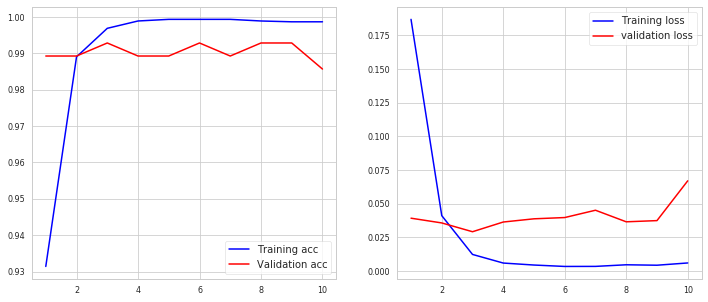

In [62]:
from keras.layers import Conv1D, MaxPool1D, GlobalMaxPooling1D, GlobalAveragePooling1D

n_epochs = 10
model_relu = Sequential()
model_relu.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
model_relu.add(Conv1D(128, 3, activation='relu'))
model_relu.add(MaxPool1D(3))
model_relu.add(Dropout(0.2))
model_relu.add(Conv1D(128, 3, activation='relu'))
model_relu.add(GlobalMaxPooling1D())
model_relu.add(Dropout(0.2))
model_relu.summary()
model_relu.add(Dense(1, activation='sigmoid'))


model_relu.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
result_relu = model_relu.fit(X_train, y_train, batch_size = batch_size, epochs=n_epochs, validation_data=(X_validate,y_validate), verbose=1)
eval_ = model_relu.evaluate(X_tester, y_tester)
print(eval_[0], eval_[1]) # loss / accuracy

plot_model(result_relu)


### Baseline Performance summary:
<ul>
    <li>Training Accuracy: 1st epoch = 0.9314 | 10th epoch = 0.9987 (improved accuracy)</li>
    <li>Validation accuracy: 1st epoch = 0.9892 | 10th epoch = 0.9857(not much improvement)</li>
    <li><strong>Training accuracy reaches plateau at ~4 epochs</strong></li>
    <li>Training loss: 1st epoch = 0.187 | 10th epoch = 0.0059 (decreased loss)</li>
    <li>Validation loss: 1st epoch = 0.0392 |10th epoch = 0.0669 (increased loss)</li>
</ul>

# Part B - trying other activation function - Leaky ReLu

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 25, 100)           873400    
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 23, 128)           38528     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 7, 128)            0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 7, 128)            0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 5, 128)            49280     
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 128)               0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)              

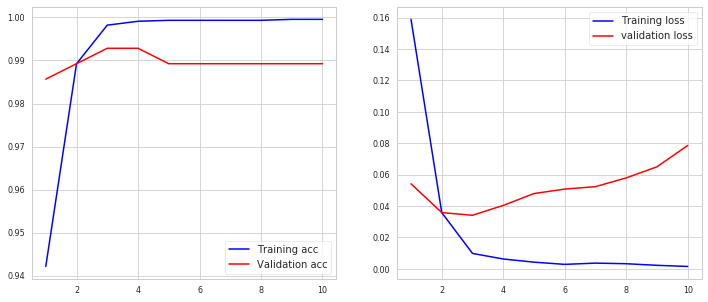

In [63]:
from keras.layers import LeakyReLU
import tensorflow as tf

from keras.layers import Conv1D, MaxPool1D, GlobalMaxPooling1D, GlobalAveragePooling1D

lrelu = lambda x: tf.keras.activations.relu(x, alpha=0.1)

n_epochs = 10
model_leakyrelu = Sequential()
model_leakyrelu.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
model_leakyrelu.add(Conv1D(128, 3, activation=lrelu))
model_leakyrelu.add(MaxPool1D(3))
model_leakyrelu.add(Dropout(0.2))
model_leakyrelu.add(Conv1D(128, 3, activation=lrelu))
model_leakyrelu.add(GlobalMaxPooling1D())
model_leakyrelu.add(Dropout(0.2))
model_leakyrelu.summary()
model_leakyrelu.add(Dense(1, activation='sigmoid'))


model_leakyrelu.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
result_leakyrelu = model_leakyrelu.fit(X_train, y_train, batch_size = batch_size, epochs=n_epochs, validation_data=(X_validate,y_validate), verbose=1)
eval_leakyrelu = model_leakyrelu.evaluate(X_tester, y_tester)
print(eval_leakyrelu[0], eval_leakyrelu[1]) # loss / accuracy

plot_model(result_leakyrelu)


### Leaky Relu Tuning Performance summary:
<ul>
    <li>Training Accuracy: 1st epoch = 0.9422(0.9314BL) | 10th epoch = 0.9996(0.9987BL) (higher accuracy achieved than BL)</li>
    <li>Validation accuracy: 1st epoch = 0.9857(0.9892BL) | 10th epoch = 0.9892(0.9857BL)(improvement but same range as BL)</li>
    <li><strong>Training accuracy reaches plateau at ~5 epochs</strong>(4 in BL)</li>
    <li>Training loss: 1st epoch = 0.1589(0.187BL) | 10th epoch = 0.0015(0.0059BL) (lower training loss than BL)</li>
    <li>Validation loss: 1st epoch = 0.0542(0.0392BL) |10th epoch = 0.0786(0.0669BL) (greater validation loss than BL)</li>
</ul>

# Part C - trying other cost function - (Binary Classification Loss Functions - Hinge Loss)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 25, 100)           873400    
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 23, 128)           38528     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 7, 128)            0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 7, 128)            0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 5, 128)            49280     
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 128)               0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)              

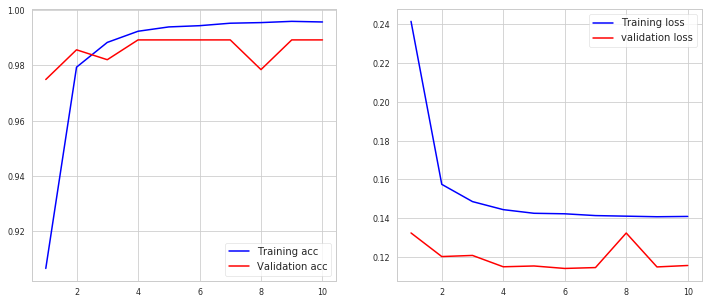

In [65]:
from keras.layers import Conv1D, MaxPool1D, GlobalMaxPooling1D, GlobalAveragePooling1D

n_epochs = 10
model_hinge = Sequential()
model_hinge.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
model_hinge.add(Conv1D(128, 3, activation='relu'))
model_hinge.add(MaxPool1D(3))
model_hinge.add(Dropout(0.2))
model_hinge.add(Conv1D(128, 3, activation='relu'))
model_hinge.add(GlobalMaxPooling1D())
model_hinge.add(Dropout(0.2))
model_hinge.summary()
model_hinge.add(Dense(1, activation='sigmoid'))


model_hinge.compile(loss='hinge', optimizer="adam", metrics=['accuracy'])
result_hinge = model_hinge.fit(X_train, y_train, batch_size = batch_size, epochs=n_epochs, validation_data=(X_validate,y_validate), verbose=1)
eval_hinge = model_hinge.evaluate(X_tester, y_tester)
print(eval_hinge[0], eval_hinge[1]) # loss / accuracy

plot_model(result_hinge)


### Hinge Loss Tuning Performance summary:
<ul>
    <li>Training Accuracy: 1st epoch = 0.9065(0.9314BL) | 10th epoch = 0.9957(0.9987BL) (lower accuracy achieved than BL)</li>
    <li>Validation accuracy: 1st epoch = 0.9749(0.9892BL) | 10th epoch = 0.9892(0.9857BL)(improvement but same max as BL)</li>
    <li><strong>Training accuracy reaches plateau at ~6-7 epochs</strong>(4 in BL)</li>
    <li>Training loss: 1st epoch = 0.2414(0.187BL) | 10th epoch = 0.1410(0.0059BL) (lot higher training loss than BL)</li>
    <li>Validation loss: 1st epoch = 0.1325(0.0392BL) |10th epoch = 0.1157(0.0669BL) (greater validation loss than BL)</li>
</ul>

# Part D - Changing number of epochs

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 25, 100)           873400    
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 23, 128)           38528     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 7, 128)            0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 7, 128)            0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 5, 128)            49280     
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 128)               0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 128)             

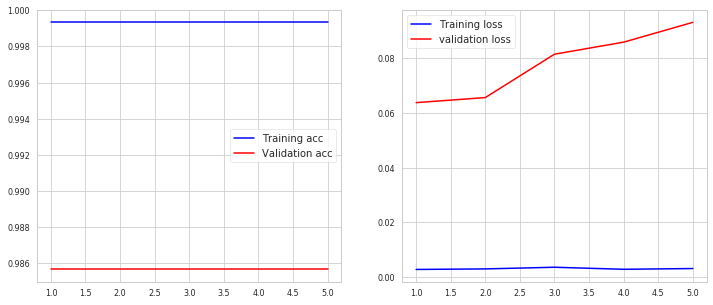

In [66]:
from keras.layers import Conv1D, MaxPool1D, GlobalMaxPooling1D, GlobalAveragePooling1D

n_epochs = 5
model_epoch = Sequential()
model_epoch.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
model_epoch.add(Conv1D(128, 3, activation='relu'))
model_epoch.add(MaxPool1D(3))
model_epoch.add(Dropout(0.2))
model_epoch.add(Conv1D(128, 3, activation='relu'))
model_epoch.add(GlobalMaxPooling1D())
model_epoch.add(Dropout(0.2))
model_epoch.summary()
model_epoch.add(Dense(1, activation='sigmoid'))


model_epoch.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
result_epoch = model_relu.fit(X_train, y_train, batch_size = batch_size, epochs=n_epochs, validation_data=(X_validate,y_validate), verbose=1)
eval_epoch = model_epoch.evaluate(X_tester, y_tester)
print(eval_epoch[0], eval_epoch[1]) # loss / accuracy

plot_model(result_epoch)


### Epoch Tuning Performance summary:

<ul>
    <li>Training Accuracy: 1st epoch = 0.9993(0.9314BL) | 5th epoch = 0.9993(0.9993BL5,0.9987BL10) (similar to BL)</li>
    <li>Validation accuracy: 1st epoch = 0.9857(0.9892BL) | 5th epoch = 0.9857(0.9892BL5,0.9857BL10)(no improvement and same low as BL)</li>
    <li><strong>Training accuracy reaches plateau at 1 epoch</strong>(4 in BL)</li>
    <li>Training loss: 1st epoch = 0.0028(0.187BL10) | 5th epoch = 0.1410(0.0044BL5,0.0059BL) (lot higher training loss than BL)</li>
    <li>Validation loss: 1st epoch = 0.1325(0.0392BL) |5th epoch = 0.1157(0.0387BL5,0.0669BL10) (greater validation loss than BL)</li>
</ul>

# Part E - Gradient Estimation Tuning - Stochastic Gradient Descent

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 25, 100)           873400    
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 23, 128)           38528     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 7, 128)            0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 7, 128)            0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 5, 128)            49280     
_________________________________________________________________
global_max_pooling1d_10 (Glo (None, 128)               0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 128)             

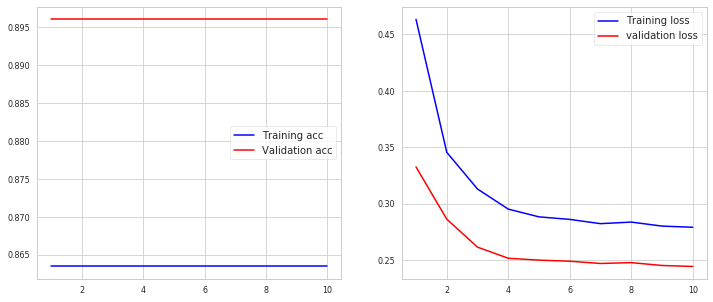

In [67]:
from keras.layers import Conv1D, MaxPool1D, GlobalMaxPooling1D, GlobalAveragePooling1D

n_epochs = 10
model_sgd = Sequential()
model_sgd.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
model_sgd.add(Conv1D(128, 3, activation='relu'))
model_sgd.add(MaxPool1D(3))
model_sgd.add(Dropout(0.2))
model_sgd.add(Conv1D(128, 3, activation='relu'))
model_sgd.add(GlobalMaxPooling1D())
model_sgd.add(Dropout(0.2))
model_sgd.summary()
model_sgd.add(Dense(1, activation='sigmoid'))


model_sgd.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['accuracy'])
result_sgd = model_sgd.fit(X_train, y_train, batch_size = batch_size, epochs=n_epochs, validation_data=(X_validate,y_validate), verbose=1)
eval_sgd = model_sgd.evaluate(X_tester, y_tester)
print(eval_sgd[0], eval_sgd[1]) # loss / accuracy

plot_model(result_sgd)


### Gradient Tuning Performance summary:
<ul>
    <li>Training Accuracy: 1st epoch = 0.8635(0.9314BL) | 10th epoch = 0.8635(0.9987BL) (constant & lower accuracy achieved than BL)</li>
    <li>Validation accuracy: 1st epoch = 0.8961(0.9892BL) | 10th epoch = 0.8961(0.9857BL)(constant & lower than BL)</li>
    <li><strong>Training accuracy reaches plateau at 1 epoch, loss at ~6epochs</strong>(4 in BL)</li>
    <li>Training loss: 1st epoch = 0.4633(0.187BL) | 10th epoch = 0.2792(0.0059BL) (lot higher training loss than BL)</li>
    <li>Validation loss: 1st epoch = 0.3326(0.0392BL) |10th epoch = 0.2445(0.0669BL) (greater validation loss than BL)</li>
</ul>

# Part F - Network Architecture Tuning (+ layer)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 25, 100)           873400    
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 23, 128)           38528     
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 7, 128)            0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 7, 128)            0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 5, 128)            49280     
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 128)               0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 128)             

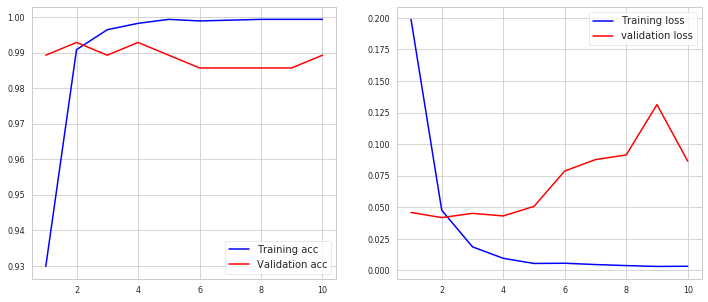

In [69]:
from keras.layers import Conv1D, MaxPool1D, GlobalMaxPooling1D, GlobalAveragePooling1D

n_epochs = 10
model_ntw = Sequential()
model_ntw.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
model_ntw.add(Conv1D(128, 3, activation='relu'))
model_ntw.add(MaxPool1D(3))
model_ntw.add(Dropout(0.2))
model_ntw.add(Conv1D(128, 3, activation='relu'))
model_ntw.add(GlobalMaxPooling1D())
model_ntw.add(Dropout(0.2))
model_ntw.add(Dense(64, activation='relu'))
model_ntw.add(Dropout(0.2))
model_ntw.add(Dense(32, activation='relu'))
model_ntw.add(Dropout(0.2))
model_ntw.summary()
model_ntw.add(Dense(1, activation='sigmoid'))


model_ntw.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
result_ntw = model_ntw.fit(X_train, y_train, batch_size = batch_size, epochs=n_epochs, validation_data=(X_validate,y_validate), verbose=1)
eval_ntw = model_ntw.evaluate(X_tester, y_tester)
print(eval_ntw[0], eval_ntw[1]) # loss / accuracy

plot_model(result_ntw)


### Network Architecture Tuning Performance summary:
<ul>
    <li>Training Accuracy: 1st epoch = 0.9298(0.9314BL) | 10th epoch = 0.9993(0.9987BL) (higher initial and final achieved than BL)</li>
    <li>Validation accuracy: 1st epoch = 0.9892(0.9892BL) | 10th epoch = 0.9892(0.9857BL)(constant & same high BL)</li>
    <li><strong>Training accuracy reaches plateau at 1 epoch, loss at ~5 epochs</strong>(4 in BL)</li>
    <li>Training loss: 1st epoch = 0.1989(0.187BL) | 10th epoch = 0.0033(0.0059BL) (high initial but low final training loss than BL)</li>
    <li>Validation loss: 1st epoch = 0.0459(0.0392BL) |10th epoch = 0.0865(0.0669BL) (greater validation loss than BL)</li>
</ul>

# Part G: Network initializers Tuning - Orthogonal

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 25, 100)           873400    
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 23, 128)           38528     
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 7, 128)            0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 7, 128)            0         
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 5, 128)            49280     
_________________________________________________________________
global_max_pooling1d_15 (Glo (None, 128)               0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 128)             

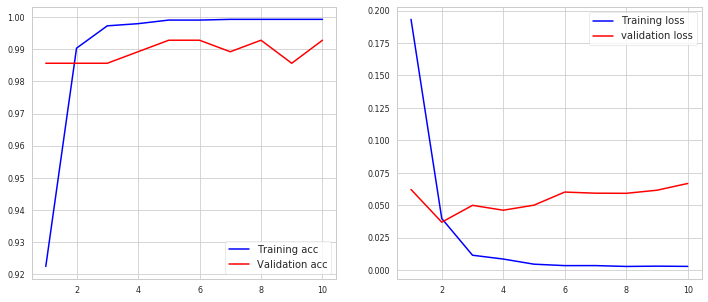

In [75]:
import keras
from keras.layers import Conv1D, MaxPool1D, GlobalMaxPooling1D, GlobalAveragePooling1D
# initializer = normal(mean=0, stddev=0.01, seed=13)
n_epochs = 10
model_init1 = Sequential()
model_init1.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
model_init1.add(Conv1D(128, 3, kernel_initializer=keras.initializers.Orthogonal(gain=1.0, seed=None), activation='relu'))
model_init1.add(MaxPool1D(3))
model_init1.add(Dropout(0.2))
model_init1.add(Conv1D(128, 3, kernel_initializer=keras.initializers.Orthogonal(gain=1.0, seed=None), activation='relu'))
model_init1.add(GlobalMaxPooling1D())
model_init1.add(Dropout(0.2))
model_init1.summary()
model_init1.add(Dense(1, activation='sigmoid'))


model_init1.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
result_init1 = model_init1.fit(X_train, y_train, batch_size = batch_size, epochs=n_epochs, validation_data=(X_validate,y_validate), verbose=1)
eval_init1 = model_init1.evaluate(X_tester, y_tester)
print(eval_init1[0], eval_init1[1]) # loss / accuracy

plot_model(result_init1)


### Orthogonal Initializer Tuning Performance summary:
<ul>
    <li>Training Accuracy: 1st epoch = 0.9224(0.9314BL) | 10th epoch = 0.9993(0.9987BL) (low initial but high final than BL)</li>
    <li>Validation accuracy: 1st epoch = 0.9857(0.9892BL) | 10th epoch = 0.9928(0.9857BL)(highest final value)</li>
    <li><strong>Training accuracy reaches plateau at 1 epoch, loss at ~5 epochs</strong>(4 in BL)</li>
    <li>Training loss: 1st epoch = 0.1932(0.187BL) | 10th epoch = 0.0029(0.0059BL) (high initial but low final training loss than BL)</li>
    <li>Validation loss: 1st epoch = 0.0621(0.0392BL) |10th epoch = 0.0668(0.0669BL) (greater validation loss than BL)</li>
</ul>

# Conclusion:
### CNN model does a good job in binary text classification. Hyperparameter tuning is extremely important in order to ensure high accuracy. Different combinations lead to different results and how each tuning affects the baseline is shown through above examples. 

### Important Citations :
https://www.kaggle.com/babakgohardani/spam-detection-with-deep-learning-methods 
https://www.kaggle.com/uciml/sms-spam-collection-dataset
https://medium.com/dair-ai/deep-learning-for-nlp-an-overview-of-recent-trends-d0d8f40a776d https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6
https://towardsdatascience.com/spam-or-ham-introduction-to-natural-language-processing-part-2-a0093185aebd 
https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/https://medium.com/syncedreview/iclr-2019-fast-as-adam-good-as-sgd-new-optimizer-has-both-78e37e8f9a34 <small>(* - *)</small>

### License:
Copyright 2020 Kartik Kumar

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.